In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [6]:
f_path = Path(ROOT_DIR, 'results', 'f')
fpw_path = Path(ROOT_DIR, 'results', 'fpw')
fsw_path = Path(ROOT_DIR, 'results', 'fsw')

split_pr_by = ["update_weight_interval"]
fp_colors = [ 'lightseagreen', 'lime', 'limegreen', 'forestgreen', 'darkgreen', 'darkolivegreen', ]
fpw_colors = ['lightcoral', 'indianred', 'brown', 'maroon']
fsw_colors = ['rebeccapurple']



def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [7]:
def process_dir(dir_path, key="reward", w=100, trunc=60000, split_by=None):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            if trunc > info[key].shape[0]:
                print(args)
                print(f"length of misbehaving data: {info[key].shape}")
                
            result = moving_avg(info[key][:trunc], w=w)
            all_results[split_by_tuple][hparams].append(result)
            
        else:
            result = moving_avg(info[key][:trunc], w=w)
            all_results.append(result)
    if split_by is not None:
        for k, v in all_results.items():
            for k1, v1 in v.items():
                all_results[k][k1] = np.array(all_results[k][k1])
        data = all_results
    else:
        data = np.array(all_results)

    
    return data


In [9]:
w = 100
f_data = process_dir(f_path, w=w)
fpw_data = process_dir(fpw_path, w=w, split_by=split_pr_by)
fsw_data = process_dir(fsw_path, w=w, split_by=split_pr_by)

In [12]:
fpw_uwi_data = sorted(fpw_data[('update_weight_interval',)].items(), key=lambda k: k[0][0])
fsw_uwi_data = sorted(fsw_data[('update_weight_interval',)].items(), key=lambda k: k[0][0])

In [14]:
all_data = [('Obs only', f_data, 'orange'),
            *[(f"One-hot state + obs (n = {k[0]})", d, fsw_colors[i]) for i, (k, d) in enumerate(fsw_uwi_data[:1])],
            *[(f"PF weights + obs (n = {k[0]})", d, fpw_colors[i]) for i, (k, d) in enumerate(fpw_uwi_data[:1])]
           ]

(30, 59901)

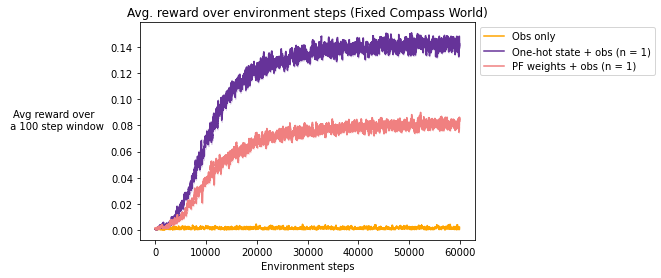

In [26]:
x = np.arange(f_data.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Avg reward over \n a {w} step window", rotation=0, labelpad=55)
ax.set_title('Avg. reward over environment steps (Fixed Compass World)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
